<a href="https://colab.research.google.com/github/silvimln/ProjectDeepLearning_UNet/blob/main/S1_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**SKENARIO 1 SKRIPSI**

**SPLIT DATA 80:20**

**BATCH SIZE KLASIFIKASI 16 & 32**

**MENGGUNAKAN UNET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Path folder ALPUKAT di Google Drive
project_path = '/content/drive/MyDrive/alpukat/dataset'
os.chdir(project_path)


# Verifikasi isi folder
!ls

images	masks


In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import os
import glob
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU, SparseCategoricalAccuracy
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd

In [ ]:
IMG_SIZE = 128
NUM_CLASSES = 3
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
image_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/images/*.*'))  # Untuk semua tipe gambar
mask_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/masks/*.*'))

print(len(image_paths))
print(len(mask_paths))

450
450


In [ ]:
label_map = {
    'miki': 0,
    'aligator': 1,
    'marcus': 2
}

labels = [label_map[os.path.basename(path).split('_')[0]] for path in image_paths]

In [ ]:
from sklearn.model_selection import train_test_split

# Gunakan stratified split untuk menjaga proporsi kelas tetap
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths, train_labels, test_labels = train_test_split(
    image_paths, mask_paths, labels,
    test_size=0.2,
    stratify=labels,   # menjaga distribusi kelas
    random_state=42
)


In [ ]:
from collections import Counter

# Hitung jumlah masing-masing label di data training
label_counts = Counter(train_labels)

# Tampilkan hasilnya
for label, count in label_counts.items():
    print(f"Label {label}: {count} data")


Label 1: 120 data
Label 2: 120 data
Label 0: 120 data


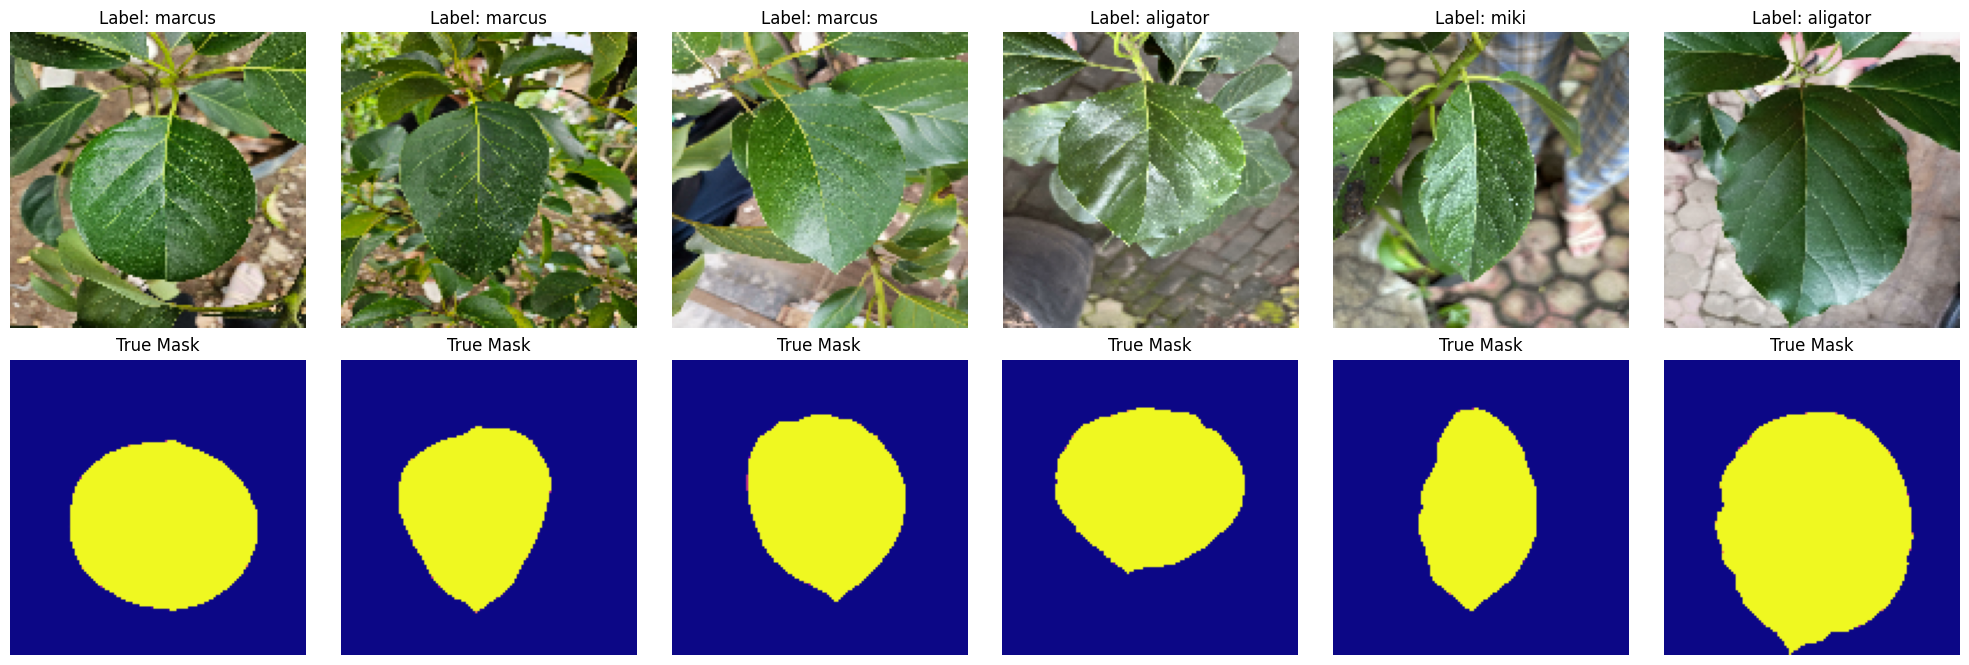

In [ ]:
# Sample 6 random image paths
sample_paths = random.sample(list(zip(image_paths, mask_paths)), 6)

plt.figure(figsize=(20, 10))

for i, (image_path, mask_path) in enumerate(sample_paths):
    # Ambil label dari nama file (misalnya, class diambil dari nama file gambar)
    class_name = os.path.basename(image_path).split('_')[0]
    label_name = class_name if class_name in label_map else 'unknown'

    # Load dan proses gambar
    img = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    img = tf.image.resize(img, (128, 128)) / 255.0

    # Load dan proses mask
    mask = tf.image.decode_jpeg(tf.io.read_file(mask_path), channels=1)  # Mask grayscale
    mask = tf.image.resize(mask, (128, 128)) / 255.0  # Resize mask agar sesuai dengan gambar

    # Plot gambar asli
    plt.subplot(3, 6, i + 1)  # Baris 1, Gambar asli
    plt.imshow(img)
    plt.title(f"Label: {label_name}")
    plt.axis('off')

    # Plot true mask
    plt.subplot(3, 6, i + 7)  # Baris 2, True mask
    plt.imshow(mask, cmap='plasma')  # Gunakan colormap untuk visualisasi mask
    plt.title("True Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

##**DATA PREPROCESSINGG**##

In [ ]:
import tensorflow as tf

# Fungsi preprocessing gambar dan mask
def load_and_preprocess_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [128, 128])
    mask = tf.cast(mask, tf.float32) / 255.0

    # Thresholding untuk membentuk mask biner
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    return image, mask


In [ ]:
# import tensorflow as tf

# def augment_unet(image_path, mask_path):
#     image, mask = load_and_preprocess_image(image_path, mask_path)

#     # Augmentasi flip horizontal
#     if tf.random.uniform(()) > 0.5:
#         image = tf.image.flip_left_right(image)
#         mask = tf.image.flip_left_right(mask)

#     # Augmentasi flip vertikal
#     if tf.random.uniform(()) > 0.5:
#         image = tf.image.flip_up_down(image)
#         mask = tf.image.flip_up_down(mask)

#     # Augmentasi rotasi (90, 180, 270, 0)
#     rotations = [0, 90, 180, 270]
#     rotation_angle = tf.random.shuffle(rotations)[0]
#     image = tf.image.rot90(image, k=rotation_angle // 90)
#     mask = tf.image.rot90(mask, k=rotation_angle // 90)

#     # Augmentasi transpose
#     if tf.random.uniform(()) > 0.5:
#         image = tf.image.transpose(image)
#         mask = tf.image.transpose(mask)

#     return image, mask

In [ ]:
train_unet_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_unet_ds = train_unet_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_unet_ds = train_unet_ds.shuffle(100).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_unet_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))
test_unet_ds = test_unet_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_unet_ds = test_unet_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [ ]:
# for image, mask in train_unet_ds.take(1):
#     print("Image shape:", image.shape)
#     print("Mask shape:", mask.shape)


Image shape: (16, 128, 128, 3)
Mask shape: (16, 128, 128, 1)


##**UNET MODEL**##

In [ ]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
# --- U-Net Segmentasi ---
def build_unet():
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # Decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Output segmentasi
    segmentation_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(u9)

    model = models.Model(inputs=inputs, outputs=segmentation_output, name='U-Net-Segmenter')
    return model

In [ ]:
# Membuat model U-Net
unet_model = build_unet()

# Menampilkan summary dari model U-Net
unet_model.summary()

Model: "U-Net-Segmenter"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 512) │          0 │ max_pooling2d_3[

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Menggunakan threshold 0.5 untuk prediksi
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [ ]:
# Kompilasi model
unet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Ganti dengan IoU loss jika sudah didefinisikan
    metrics=[iou_metric]
)

# Definisikan callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_unet1_model.h5', save_best_only=True, monitor='val_loss', mode='min')
]

In [ ]:
# Melatih model
history = unet_model.fit(
    train_unet_ds,
    epochs=100,
    validation_data=test_unet_ds,
    steps_per_epoch=len(train_unet_ds),
    validation_steps=len(test_unet_ds),
    callbacks=callbacks
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - iou_metric: 0.0502 - loss: 0.6568

23/23 ━━━━━━━━━━━━━━━━━━━━ 182s 6s/step - iou_metric: 0.0499 - loss: 0.6528 - val_iou_metric: 0.3939 - val_loss: 0.3962
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - iou_metric: 0.4329 - loss: 0.3805

23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - iou_metric: 0.4349 - loss: 0.3798 - val_iou_metric: 0.6372 - val_loss: 0.2785
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - iou_metric: 0.6261 - loss: 0.2694 - val_iou_metric: 1.6832e-11 - val_loss: 1.7210
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - iou_metric: 0.5043 - loss: 0.6625 - val_iou_metric: 0.0062 - val_loss: 0.4573
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - iou_metric: 0.0830 - loss: 0.4042 - val_iou_metric: 0.6106 - val_loss: 0.3153
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - iou_metric: 0.5893 - loss: 0.3012

23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - iou_metric: 0.5899 - loss: 0.3008 - val_iou_metric: 0.6846 - val_loss: 0.2350
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - iou_metric: 0.5979 - loss: 0.2785

23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - iou_metric: 0.5979 - loss: 0.2781 - val_iou_metric: 0.7495 - val_loss: 0.1992
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - iou_metric: 0.6634 - loss: 0.4932 - val_iou_metric: 5.2220e-06 - val_loss: 1.1924
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - iou_metric: 0.0298 - loss: 0.8852 - val_iou_metric: 5.0383e-05 - val_loss: 0.4053
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - iou_metric: 0.1006 - loss: 0.4917 - val_iou_metric: 1.6832e-11 - val_loss: 0.5179
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - iou_metric: 0.0593 - loss: 0.4530 - val_iou_metric: 0.6460 - val_loss: 0.3363
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - iou_metric: 0.5131 - loss: 0.3490 - val_iou_metric: 0.0666 - val_loss: 0.5547
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - iou_metric: 0.3483 - loss: 0.3995 - val_iou_metric: 0.5873 - val_loss: 0.3033
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - iou_metric: 0.4861 - loss

In [ ]:
# Simpan history ke file JSON
history_dict = history.history
with open('training_history1.json', 'w') as json_file:
    json.dump(history_dict, json_file)

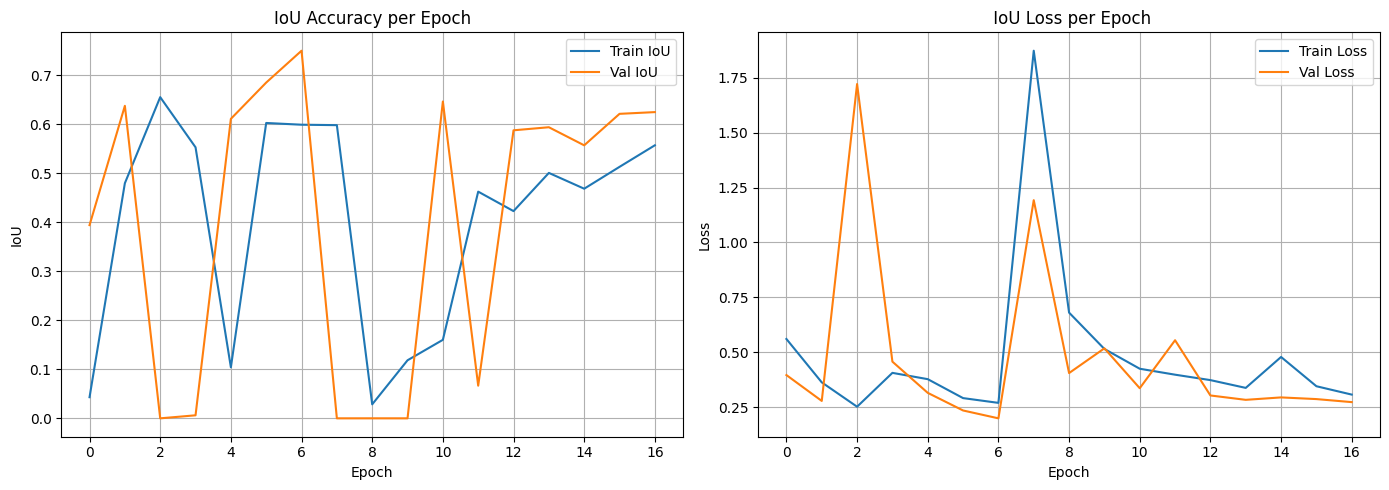

In [ ]:
# Ekstrak data dari history
history_dict = history.history

# Buat plot
plt.figure(figsize=(14, 5))

# Plot IoU (iou_metric)
plt.subplot(1, 2, 1)
plt.plot(history_dict['iou_metric'], label='Train IoU')
plt.plot(history_dict['val_iou_metric'], label='Val IoU')
plt.title('IoU Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title(' IoU Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


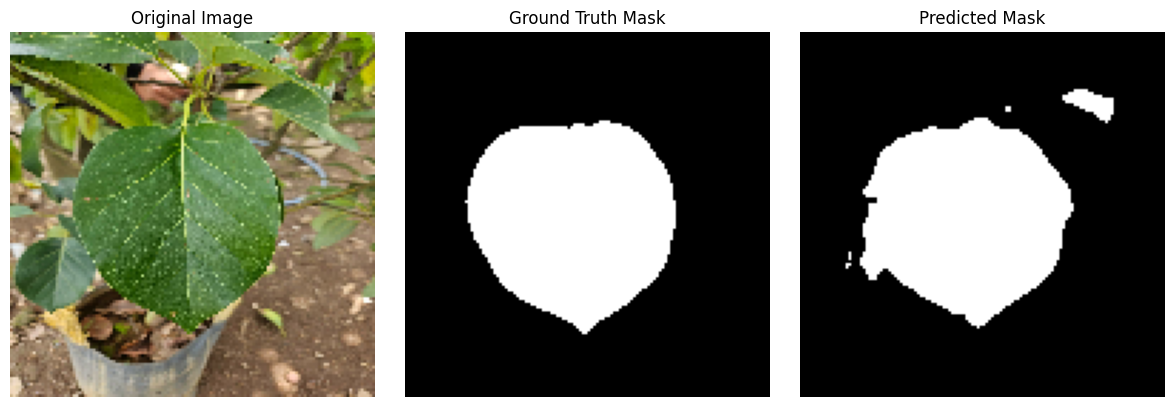

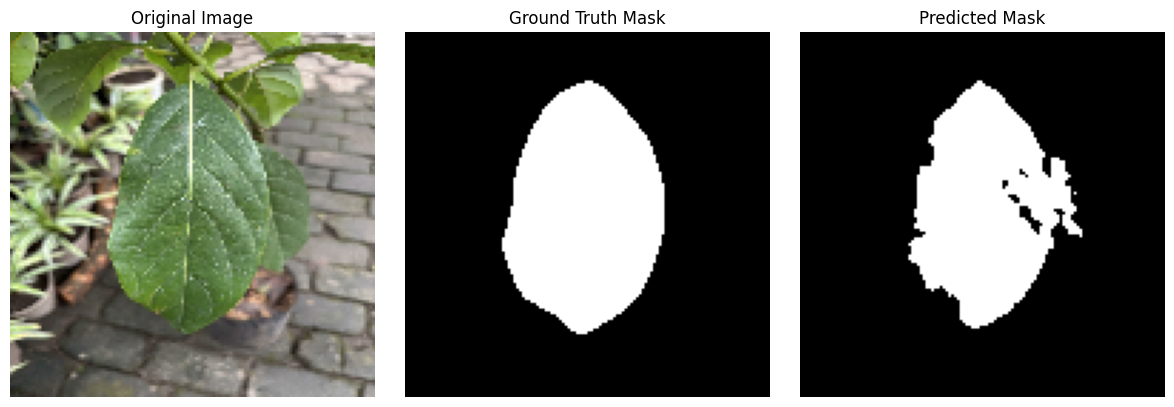

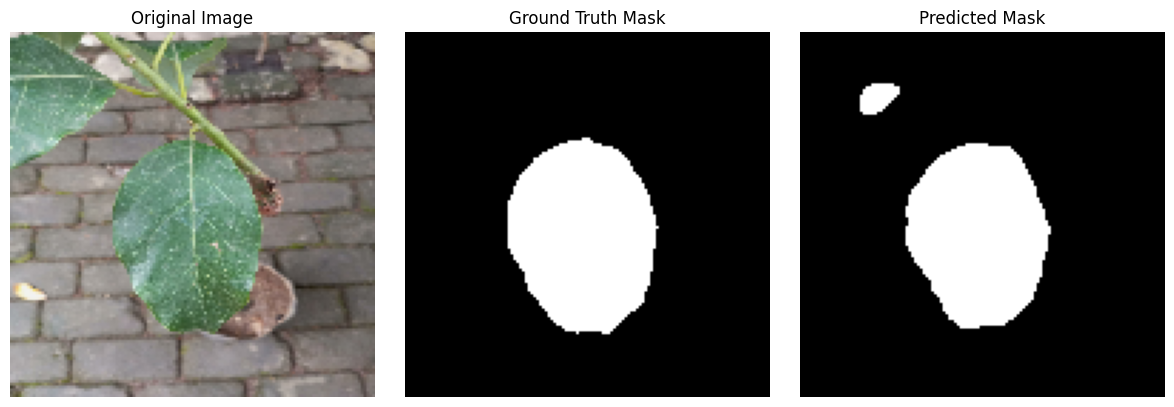

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_sample_prediction(unet_model, dataset, num_samples=3):
    for images, masks in dataset.take(1):
        preds = unet_model.predict(images)
        preds = (preds > 0.5).astype(np.uint8)  # Threshold prediksi

        for i in range(num_samples):
            image = images[i].numpy()
            gt_mask = masks[i].numpy().squeeze()
            pred_mask = preds[i].squeeze()

            plt.figure(figsize=(12, 4))

            # Gambar asli
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

display_sample_prediction(unet_model, test_unet_ds, num_samples=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


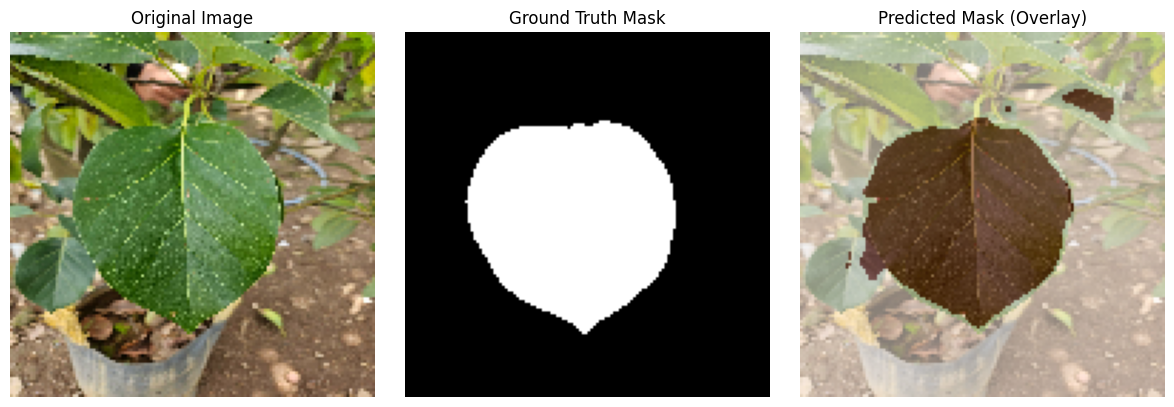

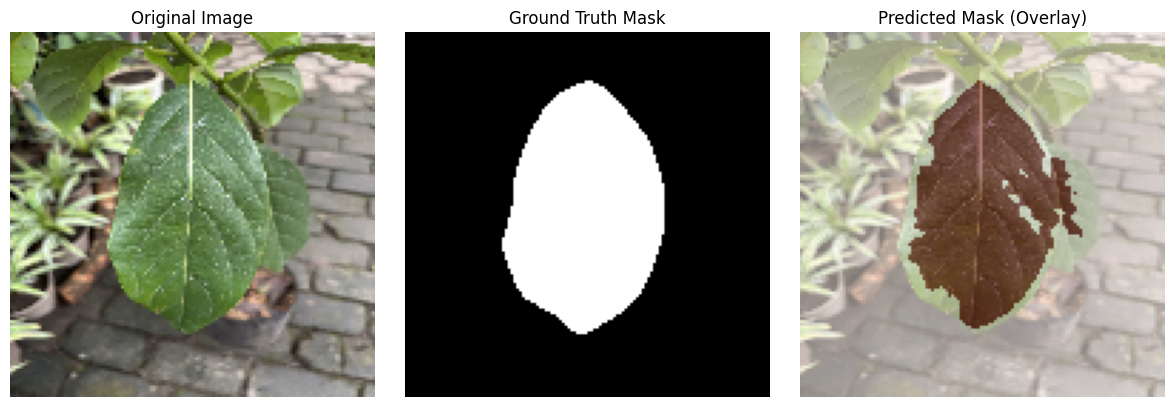

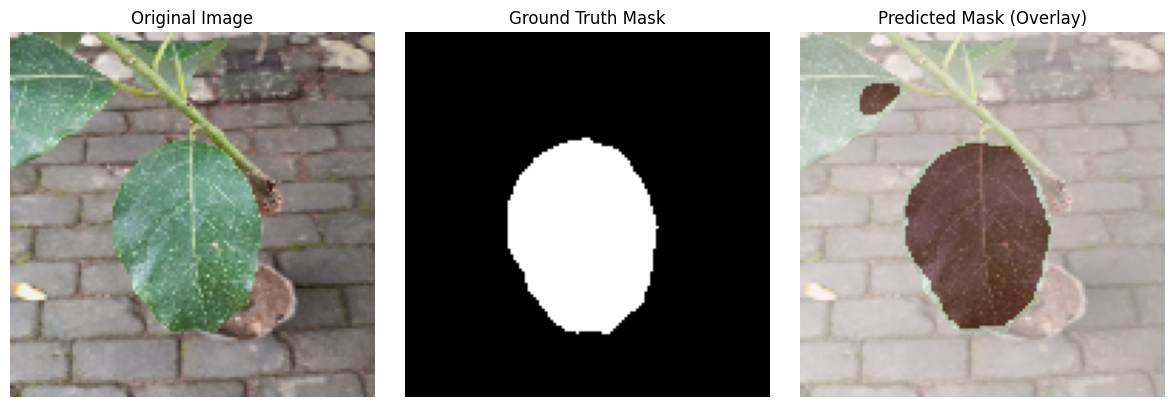

In [ ]:
def display_sample_prediction(unet_model, dataset, num_samples=3):
    for images, masks in dataset.take(1):
        preds = unet_model.predict(images)
        preds = (preds > 0.5).astype(np.uint8)  # Threshold prediksi

        for i in range(num_samples):
            image = images[i].numpy()
            gt_mask = masks[i].numpy().squeeze()
            pred_mask = preds[i].squeeze()

            plt.figure(figsize=(12, 4))

            # Gambar asli
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted mask overlay dengan gambar asli
            plt.subplot(1, 3, 3)
            plt.imshow(image)
            plt.imshow(pred_mask, cmap='Reds', alpha=0.5)  # Overlay mask
            plt.title("Predicted Mask (Overlay)")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

display_sample_prediction(unet_model, test_unet_ds, num_samples=3)

##**CLASSIFICATION MODEL**##

In [ ]:
# from tensorflow.keras.models import load_model

# # Load model U-Net dari checkpoint
# unet_model = load_model('/content/drive/MyDrive/alpukat/dataset/best_unet1_model.h5')

In [ ]:
# Gunakan lowercase untuk key
keys_tensor = tf.constant([k.lower() for k in label_map.keys()])
vals_tensor = tf.constant(list(label_map.values()), dtype=tf.int32)
table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
label_table = tf.lookup.StaticHashTable(table_init, default_value=-1)

def extract_label_from_filename_tf(filename):
    filename = tf.strings.lower(filename)
    label_str = tf.strings.split(filename, '_')[0]
    return label_table.lookup(label_str)

In [ ]:
def apply_unet_segmentation_to_image(image, segmentation_output, threshold=0.5):
    if isinstance(image, tf.Tensor):
        image = tf.cast(image, tf.float32)

    if image.shape[-1] != 3:
        raise ValueError(f"Image must have 3 channels. Got shape: {image.shape}")

    binary_mask = tf.cast(segmentation_output > threshold, tf.float32)
    if len(binary_mask.shape) == 2:
        binary_mask = tf.expand_dims(binary_mask, axis=-1)
    binary_mask_rgb = tf.repeat(binary_mask, repeats=3, axis=-1)

    if binary_mask_rgb.shape != image.shape:
        binary_mask_rgb = tf.image.resize(binary_mask_rgb, image.shape[:2])

    masked_image = image * binary_mask_rgb
    return masked_image

In [ ]:
from tqdm import tqdm

def save_masked_dataset(image_paths, unet_model, save_dir, image_size=(128, 128)):
    os.makedirs(save_dir, exist_ok=True)
    for path in tqdm(image_paths):
        # Load & resize
        image_raw = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0

        # Predict mask
        pred = unet_model(tf.expand_dims(image, 0), training=False)
        pred = tf.squeeze(pred, axis=0)

        # Apply mask
        masked_image = apply_unet_segmentation_to_image(image, pred)

        # Simpan hasil
        fname = os.path.basename(path)
        save_path = os.path.join(save_dir, fname)
        masked_uint8 = tf.image.convert_image_dtype(masked_image, tf.uint8)
        encoded = tf.image.encode_jpeg(masked_uint8)
        tf.io.write_file(save_path, encoded)


In [ ]:
save_masked_dataset(train_image_paths, unet_model, "maskedunet1_train")
save_masked_dataset(test_image_paths, unet_model, "maskedunet1_test")

100%|██████████| 90/90 [00:16<00:00,  5.57it/s]


In [ ]:
def load_masked_dataset(image_dir):
    image_paths = tf.io.gfile.glob(os.path.join(image_dir, '*.jpg'))
    ds = tf.data.Dataset.from_tensor_slices(image_paths)

    def load_image_and_label(path):
        image_raw = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.image.resize(image, [128, 128])
        image = tf.cast(image, tf.float32) / 255.0

        filename = tf.strings.split(path, '/')[-1]
        label = extract_label_from_filename_tf(filename)
        return image, label

    return ds.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# Batching dan prefetch
classification_train_ds_16 = load_masked_dataset("maskedunet1_train").batch(16).prefetch(tf.data.AUTOTUNE)
classification_test_ds_16 = load_masked_dataset("maskedunet1_test").batch(16).prefetch(tf.data.AUTOTUNE)

classification_train_ds_32 = load_masked_dataset("maskedunet1_train").batch(32).prefetch(tf.data.AUTOTUNE)
classification_test_ds_32 = load_masked_dataset("maskedunet1_test").batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# def extract_label_from_filename(filename):
#     filename_str = filename.numpy().decode() if isinstance(filename, tf.Tensor) else str(filename)
#     label_name = filename_str.split('_')[0].lower()
#     return tf.constant(labell_map.get(label_name, -1))  # -1

In [ ]:
# def apply_unet_segmentation_to_image(image, segmentation_output, threshold=0.5):
#     if isinstance(image, tf.Tensor):
#         image = tf.cast(image, tf.float32)

#     if image.shape[-1] != 3:
#         raise ValueError(f"Image must have 3 channels. Got shape: {image.shape}")

#     binary_mask = tf.cast(segmentation_output > threshold, tf.float32)
#     if len(binary_mask.shape) == 2:
#         binary_mask = tf.expand_dims(binary_mask, axis=-1)
#     binary_mask_rgb = tf.repeat(binary_mask, repeats=3, axis=-1)

#     if binary_mask_rgb.shape != image.shape:
#         binary_mask_rgb = tf.image.resize(binary_mask_rgb, image.shape[:2])

#     masked_image = image * binary_mask_rgb
#     return masked_image

# def extract_and_apply_mask(image, unet_model):
#     image_expanded = tf.expand_dims(image, 0)
#     pred_mask = unet_model(image_expanded, training=False)
#     pred_mask = tf.squeeze(pred_mask, axis=0)
#     return apply_unet_segmentation_to_image(image, pred_mask)

In [ ]:
# def create_classification_dataset(image_paths, unet_model):
#     images, labels = [], []

#     for path in image_paths:
#         path = str(path)
#         filename = tf.strings.split(path, '/')[-1]
#         label_tensor = extract_label_from_filename(filename)
#         label = int(label_tensor.numpy())

#         image_raw = tf.io.read_file(path)
#         image = tf.image.decode_jpeg(image_raw, channels=3)
#         image = tf.image.resize(image, [128, 128])
#         image = tf.cast(image, tf.float32) / 255.0

#         masked_image = extract_and_apply_mask(image, unet_model)

#         images.append(masked_image)
#         labels.append(label)

#     dataset = tf.data.Dataset.from_tensor_slices((images, labels))
#     return dataset.shuffle(100).prefetch(tf.data.AUTOTUNE)

In [ ]:
# # Membuat dataset
# classification_train_ds_16 = create_classification_dataset(train_image_paths, unet_model)
# classification_test_ds_16 = create_classification_dataset(test_image_paths, unet_model)

# # Batching di luar fungsi create_classification_dataset
# classification_train_ds_16 = classification_train_ds_16.batch(16).prefetch(tf.data.AUTOTUNE)
# classification_test_ds_16 = classification_test_ds_16.batch(16).prefetch(tf.data.AUTOTUNE)

# classification_train_ds_32 = create_classification_dataset(train_image_paths, unet_model)
# classification_test_ds_32 = create_classification_dataset(test_image_paths, unet_model)

# classification_train_ds_32 = classification_train_ds_32.batch(32).prefetch(tf.data.AUTOTUNE)
# classification_test_ds_32 = classification_test_ds_32.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
def classification_model(input_shape=(128, 128, 3)):
    inputs = tf.keras.layers.Input(input_shape)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

    return tf.keras.models.Model(inputs, outputs)


In [ ]:
clf_model_class1 = classification_model()
clf_model_class2 = classification_model()

clf_model_class1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
clf_model_class1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

clf_model_class2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Definisikan callbacks
callbacks_class1 = [
    ModelCheckpoint('best_class1_unet1.h5', save_best_only=True, monitor='val_loss', mode='min')
]

callbacks_class2 = [
    ModelCheckpoint('best_class2_unet1.h5', save_best_only=True, monitor='val_loss', mode='min')
]

##***TRAINING CLASS BS 16***##

In [ ]:
history_class1 = clf_model_class1.fit(
    classification_train_ds_16,   # dataset sudah dibatch dengan batch size 16
    validation_data=classification_test_ds_16,   # dataset validation juga sudah dibatch
    epochs=100,
    callbacks=callbacks_class1
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3851 - loss: 1.1037

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.3846 - loss: 1.1037 - val_accuracy: 0.4222 - val_loss: 1.0982
Epoch 2/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3288 - loss: 1.0990

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3299 - loss: 1.0989 - val_accuracy: 0.3444 - val_loss: 1.0973
Epoch 3/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3870 - loss: 1.0965

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3841 - loss: 1.0965 - val_accuracy: 0.3556 - val_loss: 1.0934
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3122 - loss: 1.0987

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3138 - loss: 1.0986 - val_accuracy: 0.3778 - val_loss: 1.0873
Epoch 5/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3266 - loss: 1.0978

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.3292 - loss: 1.0972 - val_accuracy: 0.4889 - val_loss: 1.0724
Epoch 6/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3345 - loss: 1.0912

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3381 - loss: 1.0902 - val_accuracy: 0.3778 - val_loss: 1.0527
Epoch 7/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3962 - loss: 1.0849

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3986 - loss: 1.0843 - val_accuracy: 0.4333 - val_loss: 1.0393
Epoch 8/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4738 - loss: 1.0554

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4717 - loss: 1.0560 - val_accuracy: 0.5333 - val_loss: 1.0317
Epoch 9/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4732 - loss: 1.0214

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4697 - loss: 1.0223 - val_accuracy: 0.5889 - val_loss: 0.9889
Epoch 10/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5296 - loss: 0.9947

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5260 - loss: 0.9967 - val_accuracy: 0.5667 - val_loss: 0.9595
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5888 - loss: 0.9570

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5865 - loss: 0.9580 - val_accuracy: 0.5444 - val_loss: 0.9213
Epoch 12/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5994 - loss: 0.9322

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5942 - loss: 0.9356 - val_accuracy: 0.5222 - val_loss: 0.9176
Epoch 13/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5986 - loss: 0.9129

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5987 - loss: 0.9136 - val_accuracy: 0.6444 - val_loss: 0.8272
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6469 - loss: 0.8411 - val_accuracy: 0.5556 - val_loss: 0.8570
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5789 - loss: 0.8900 - val_accuracy: 0.5889 - val_loss: 0.8303
Epoch 16/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6380 - loss: 0.8377

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6344 - loss: 0.8418 - val_accuracy: 0.6444 - val_loss: 0.7801
Epoch 17/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6828 - loss: 0.8152

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6826 - loss: 0.8151 - val_accuracy: 0.6778 - val_loss: 0.7414
Epoch 18/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6524 - loss: 0.7910

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6524 - loss: 0.7910 - val_accuracy: 0.6778 - val_loss: 0.7257
Epoch 19/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6722 - loss: 0.7842 - val_accuracy: 0.6333 - val_loss: 0.7268
Epoch 20/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7040 - loss: 0.7293

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7032 - loss: 0.7308 - val_accuracy: 0.6889 - val_loss: 0.6973
Epoch 21/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7010 - loss: 0.7009

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7016 - loss: 0.7018 - val_accuracy: 0.7556 - val_loss: 0.6215
Epoch 22/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7480 - loss: 0.6477

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7476 - loss: 0.6483 - val_accuracy: 0.7444 - val_loss: 0.5738
Epoch 23/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7663 - loss: 0.6356

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7631 - loss: 0.6396 - val_accuracy: 0.7889 - val_loss: 0.5633
Epoch 24/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7731 - loss: 0.5921

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7713 - loss: 0.5972 - val_accuracy: 0.7889 - val_loss: 0.5342
Epoch 25/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7561 - loss: 0.6246 - val_accuracy: 0.6889 - val_loss: 0.6391
Epoch 26/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7890 - loss: 0.5886 - val_accuracy: 0.7444 - val_loss: 0.5760
Epoch 27/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7613 - loss: 0.5966 - val_accuracy: 0.7333 - val_loss: 0.5667
Epoch 28/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7819 - loss: 0.5723 - val_accuracy: 0.7667 - val_loss: 0.5463
Epoch 29/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7821 - loss: 0.5691

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7820 - loss: 0.5694 - val_accuracy: 0.7556 - val_loss: 0.4970
Epoch 30/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8121 - loss: 0.5208 - val_accuracy: 0.7778 - val_loss: 0.4974
Epoch 31/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.8450 - loss: 0.4944 - val_accuracy: 0.7667 - val_loss: 0.5443
Epoch 32/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7835 - loss: 0.5242

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7830 - loss: 0.5271 - val_accuracy: 0.8000 - val_loss: 0.4940
Epoch 33/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8167 - loss: 0.5172

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8147 - loss: 0.5189 - val_accuracy: 0.7889 - val_loss: 0.4815
Epoch 34/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7929 - loss: 0.5159 - val_accuracy: 0.8000 - val_loss: 0.4903
Epoch 35/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7964 - loss: 0.4888

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7955 - loss: 0.4907 - val_accuracy: 0.8222 - val_loss: 0.4646
Epoch 36/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8298 - loss: 0.4561 - val_accuracy: 0.8222 - val_loss: 0.4821
Epoch 37/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8311 - loss: 0.4856 - val_accuracy: 0.8222 - val_loss: 0.5189
Epoch 38/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8106 - loss: 0.4619

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8095 - loss: 0.4630 - val_accuracy: 0.8222 - val_loss: 0.4571
Epoch 39/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8207 - loss: 0.4621

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8203 - loss: 0.4627 - val_accuracy: 0.8333 - val_loss: 0.4514
Epoch 40/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8112 - loss: 0.4325 - val_accuracy: 0.8000 - val_loss: 0.4550
Epoch 41/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8366 - loss: 0.4254 - val_accuracy: 0.8111 - val_loss: 0.4595
Epoch 42/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8281 - loss: 0.4163 - val_accuracy: 0.8111 - val_loss: 0.4662
Epoch 43/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8409 - loss: 0.4229

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8384 - loss: 0.4252 - val_accuracy: 0.8000 - val_loss: 0.4287
Epoch 44/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8175 - loss: 0.4528

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8174 - loss: 0.4528 - val_accuracy: 0.8222 - val_loss: 0.4233
Epoch 45/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8366 - loss: 0.4017 - val_accuracy: 0.8222 - val_loss: 0.4395
Epoch 46/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8169 - loss: 0.4212 - val_accuracy: 0.8222 - val_loss: 0.4839
Epoch 47/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8519 - loss: 0.4216

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8514 - loss: 0.4221 - val_accuracy: 0.8444 - val_loss: 0.4157
Epoch 48/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8428 - loss: 0.3818

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8424 - loss: 0.3826 - val_accuracy: 0.8556 - val_loss: 0.4110
Epoch 49/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8491 - loss: 0.3834 - val_accuracy: 0.8222 - val_loss: 0.4190
Epoch 50/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8378 - loss: 0.3874

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8370 - loss: 0.3884 - val_accuracy: 0.8556 - val_loss: 0.3999
Epoch 51/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8587 - loss: 0.3772 - val_accuracy: 0.8111 - val_loss: 0.4567
Epoch 52/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8474 - loss: 0.3671 - val_accuracy: 0.8444 - val_loss: 0.4270
Epoch 53/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8218 - loss: 0.3857 - val_accuracy: 0.7889 - val_loss: 0.4445
Epoch 54/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8812 - loss: 0.3523 - val_accuracy: 0.8556 - val_loss: 0.4354
Epoch 55/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8347 - loss: 0.3988 - val_accuracy: 0.8556 - val_loss: 0.4105
Epoch 56/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8648 - loss: 0.3385

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8639 - loss: 0.3410 - val_accuracy: 0.8556 - val_loss: 0.3919
Epoch 57/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8643 - loss: 0.3436 - val_accuracy: 0.8444 - val_loss: 0.3986
Epoch 58/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8784 - loss: 0.3428 - val_accuracy: 0.8667 - val_loss: 0.3951
Epoch 59/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8730 - loss: 0.3523

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8727 - loss: 0.3526 - val_accuracy: 0.8667 - val_loss: 0.3845
Epoch 60/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8918 - loss: 0.3204 - val_accuracy: 0.8444 - val_loss: 0.4116
Epoch 61/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8629 - loss: 0.3492 - val_accuracy: 0.8444 - val_loss: 0.3972
Epoch 62/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8832 - loss: 0.3288 - val_accuracy: 0.8667 - val_loss: 0.4077
Epoch 63/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8838 - loss: 0.3150 - val_accuracy: 0.8556 - val_loss: 0.4590
Epoch 64/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8666 - loss: 0.3277 - val_accuracy: 0.8000 - val_loss: 0.4338
Epoch 65/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8638 - loss: 0.3377 - val_accuracy: 0.8333 - val_loss: 0.4201
Epoch 66/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8936 - loss: 0.2759

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8932 - loss: 0.2764 - val_accuracy: 0.8222 - val_loss: 0.3813
Epoch 67/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8860 - loss: 0.3010 - val_accuracy: 0.8333 - val_loss: 0.3826
Epoch 68/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8894 - loss: 0.3160 - val_accuracy: 0.8556 - val_loss: 0.4349
Epoch 69/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8764 - loss: 0.3240 - val_accuracy: 0.8222 - val_loss: 0.4105
Epoch 70/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8939 - loss: 0.2596 - val_accuracy: 0.8333 - val_loss: 0.4453
Epoch 71/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8914 - loss: 0.3105 - val_accuracy: 0.8000 - val_loss: 0.4158
Epoch 72/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8715 - loss: 0.2935 - val_accuracy: 0.8111 - val_loss: 0.4071
Epoch 73/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8742 - loss: 0.3229 - val_accuracy: 0.8333 

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.8768 - loss: 0.3512 - val_accuracy: 0.8444 - val_loss: 0.3690
Epoch 77/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8768 - loss: 0.3123 - val_accuracy: 0.8444 - val_loss: 0.4045
Epoch 78/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8975 - loss: 0.2929 - val_accuracy: 0.8444 - val_loss: 0.3990
Epoch 79/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9051 - loss: 0.2787 - val_accuracy: 0.7778 - val_loss: 0.4314
Epoch 80/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8778 - loss: 0.3135 - val_accuracy: 0.7889 - val_loss: 0.4358
Epoch 81/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8735 - loss: 0.3003 - val_accuracy: 0.8000 - val_loss: 0.4083
Epoch 82/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.8951 - loss: 0.2650 - val_accuracy: 0.8111 - val_loss: 0.4036
Epoch 83/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9032 - loss: 0.2945 - val_accuracy: 0.7778 

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.8777 - loss: 0.2835 - val_accuracy: 0.8333 - val_loss: 0.3508
Epoch 90/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8806 - loss: 0.3033 - val_accuracy: 0.8889 - val_loss: 0.3824
Epoch 91/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8868 - loss: 0.2535 - val_accuracy: 0.8333 - val_loss: 0.3892
Epoch 92/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9055 - loss: 0.2650 - val_accuracy: 0.8556 - val_loss: 0.3750
Epoch 93/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9047 - loss: 0.2588 - val_accuracy: 0.8444 - val_loss: 0.3866
Epoch 94/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9161 - loss: 0.2505 - val_accuracy: 0.8333 - val_loss: 0.3851
Epoch 95/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8915 - loss: 0.2447

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8927 - loss: 0.2445 - val_accuracy: 0.9000 - val_loss: 0.3441
Epoch 96/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9284 - loss: 0.2164

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9277 - loss: 0.2179 - val_accuracy: 0.8667 - val_loss: 0.3354
Epoch 97/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9331 - loss: 0.2227 - val_accuracy: 0.8667 - val_loss: 0.3625
Epoch 98/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9308 - loss: 0.2230 - val_accuracy: 0.8667 - val_loss: 0.3901
Epoch 99/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9234 - loss: 0.2396 - val_accuracy: 0.8556 - val_loss: 0.4401
Epoch 100/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8943 - loss: 0.2997 - val_accuracy: 0.8778 - val_loss: 0.3667


In [ ]:
label_map = {
    0: "miki",
    1: "aligator",
    2: "marcus"
}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


<Figure size 800x600 with 0 Axes>

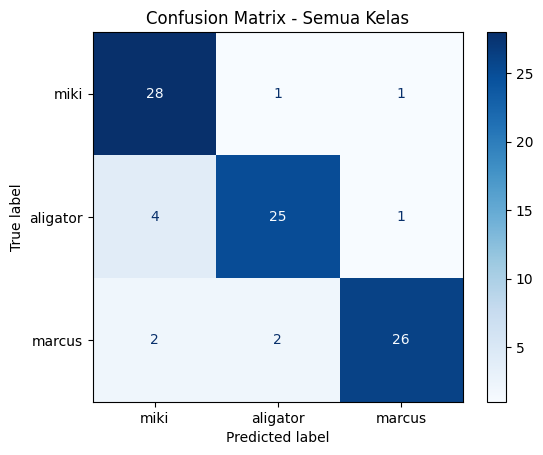

Classification Report - Semua Kelas:
              precision    recall  f1-score   support

        miki       0.82      0.93      0.88        30
    aligator       0.89      0.83      0.86        30
      marcus       0.93      0.87      0.90        30

    accuracy                           0.88        90
   macro avg       0.88      0.88      0.88        90
weighted avg       0.88      0.88      0.88        90

              precision    recall  f1-score    support
miki           0.823529  0.933333  0.875000  30.000000
aligator       0.892857  0.833333  0.862069  30.000000
marcus         0.928571  0.866667  0.896552  30.000000
accuracy       0.877778  0.877778  0.877778   0.877778
macro avg      0.881653  0.877778  0.877874  90.000000
weighted avg   0.881653  0.877778  0.877874  90.000000


In [ ]:
# Inisialisasi
y_true_all = []
y_pred_all = []

# Loop untuk mengumpulkan prediksi dan label dari seluruh test data
for image_batch, label_batch in classification_test_ds_16:
    predictions = clf_model_class1.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true_all.extend(label_batch.numpy())
    y_pred_all.extend(predicted_labels)

# Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
display_labels = [label_map[i] for i in sorted(set(y_true_all + y_pred_all))]  # label_map = {0: "Kelas 1", 1: "Kelas 2", 2: "Kelas 3"}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Visualisasi
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Semua Kelas")
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report - Semua Kelas:")
print(classification_report(y_true_all, y_pred_all, target_names=display_labels))

# (Opsional) Tampilkan sebagai DataFrame
report_df = pd.DataFrame(
    classification_report(
        y_true_all,
        y_pred_all,
        target_names=display_labels,
        output_dict=True
)
).transpose()
print(report_df)

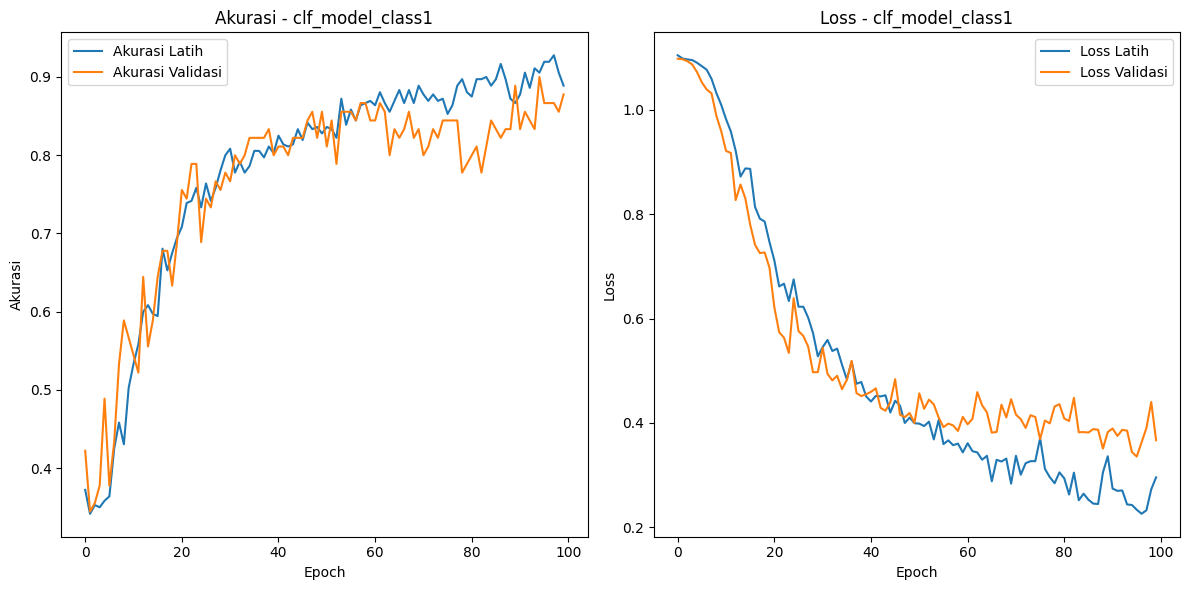

In [ ]:
import matplotlib.pyplot as plt

# Plot History untuk clf_model_class1
plt.figure(figsize=(12, 6))

# Plot Akurasi dan Loss untuk clf_model_class1
plt.subplot(1, 2, 1)  # Subplot pertama untuk akurasi
plt.plot(history_class1.history['accuracy'], label='Akurasi Latih')
plt.plot(history_class1.history['val_accuracy'], label='Akurasi Validasi')
plt.title("Akurasi - clf_model_class1")
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='best')

plt.subplot(1, 2, 2)  # Subplot kedua untuk loss
plt.plot(history_class1.history['loss'], label='Loss Latih')
plt.plot(history_class1.history['val_loss'], label='Loss Validasi')
plt.title("Loss - clf_model_class1")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

##***TRAINING CLASS BS 32***##

In [ ]:
history_class2 = clf_model_class2.fit(
    classification_train_ds_32,   # dataset sudah dibatch dengan batch size 32
    validation_data=classification_test_ds_32,   # dataset validation juga sudah dibatch
    epochs=100,
    callbacks=callbacks_class2
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.3552 - loss: 1.0995

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 468ms/step - accuracy: 0.3558 - loss: 1.0993 - val_accuracy: 0.3333 - val_loss: 1.0913
Epoch 2/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3107 - loss: 1.1006

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.3172 - loss: 1.1000 - val_accuracy: 0.3556 - val_loss: 1.0909
Epoch 3/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3519 - loss: 1.0967

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.3546 - loss: 1.0963 - val_accuracy: 0.4222 - val_loss: 1.0880
Epoch 4/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3768 - loss: 1.0911

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.3803 - loss: 1.0908 - val_accuracy: 0.3556 - val_loss: 1.0794
Epoch 5/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3329 - loss: 1.0995

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.3347 - loss: 1.0988 - val_accuracy: 0.4667 - val_loss: 1.0746
Epoch 6/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4817 - loss: 1.0795

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.4807 - loss: 1.0793 - val_accuracy: 0.4778 - val_loss: 1.0587
Epoch 7/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4869 - loss: 1.0556

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.4829 - loss: 1.0548 - val_accuracy: 0.5222 - val_loss: 1.0306
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.4714 - loss: 1.0300 - val_accuracy: 0.5222 - val_loss: 1.0316
Epoch 9/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4760 - loss: 1.0175

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.4737 - loss: 1.0204 - val_accuracy: 0.5111 - val_loss: 1.0140
Epoch 10/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5229 - loss: 0.9998

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5190 - loss: 1.0016 - val_accuracy: 0.5444 - val_loss: 0.9689
Epoch 11/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5554 - loss: 0.9888

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5516 - loss: 0.9903 - val_accuracy: 0.5667 - val_loss: 0.9474
Epoch 12/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5286 - loss: 0.9628

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.5289 - loss: 0.9638 - val_accuracy: 0.6111 - val_loss: 0.9198
Epoch 13/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6332 - loss: 0.9081

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.6242 - loss: 0.9130 - val_accuracy: 0.6333 - val_loss: 0.8887
Epoch 14/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5506 - loss: 0.9101

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.5488 - loss: 0.9131 - val_accuracy: 0.6444 - val_loss: 0.8486
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5660 - loss: 0.9167 - val_accuracy: 0.6889 - val_loss: 0.8501
Epoch 16/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6336 - loss: 0.8582

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.6323 - loss: 0.8583 - val_accuracy: 0.6889 - val_loss: 0.7991
Epoch 17/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6446 - loss: 0.8211

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.6429 - loss: 0.8276 - val_accuracy: 0.7000 - val_loss: 0.7474
Epoch 18/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6630 - loss: 0.7937

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6640 - loss: 0.7970 - val_accuracy: 0.6667 - val_loss: 0.7389
Epoch 19/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6113 - loss: 0.7978

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.6113 - loss: 0.7998 - val_accuracy: 0.7000 - val_loss: 0.7173
Epoch 20/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6518 - loss: 0.7716

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.6575 - loss: 0.7696 - val_accuracy: 0.7222 - val_loss: 0.6572
Epoch 21/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.7128 - loss: 0.7010 - val_accuracy: 0.7000 - val_loss: 0.6901
Epoch 22/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7300 - loss: 0.6952

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.7323 - loss: 0.6935 - val_accuracy: 0.7889 - val_loss: 0.5614
Epoch 23/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.7554 - loss: 0.6334 - val_accuracy: 0.7333 - val_loss: 0.6173
Epoch 24/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7311 - loss: 0.6419

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7319 - loss: 0.6434 - val_accuracy: 0.7444 - val_loss: 0.5578
Epoch 25/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7651 - loss: 0.6383

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7628 - loss: 0.6393 - val_accuracy: 0.7889 - val_loss: 0.5189
Epoch 26/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.7941 - loss: 0.5915 - val_accuracy: 0.7222 - val_loss: 0.6206
Epoch 27/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.7745 - loss: 0.6095 - val_accuracy: 0.7778 - val_loss: 0.5234
Epoch 28/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7521 - loss: 0.5991

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.7539 - loss: 0.5978 - val_accuracy: 0.7778 - val_loss: 0.4924
Epoch 29/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8086 - loss: 0.5176

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.8073 - loss: 0.5212 - val_accuracy: 0.7778 - val_loss: 0.4904
Epoch 30/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7733 - loss: 0.5426

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7740 - loss: 0.5468 - val_accuracy: 0.7778 - val_loss: 0.4720
Epoch 31/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.7717 - loss: 0.5877 - val_accuracy: 0.7889 - val_loss: 0.5216
Epoch 32/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.7745 - loss: 0.5453 - val_accuracy: 0.7444 - val_loss: 0.5232
Epoch 33/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.7875 - loss: 0.5185 - val_accuracy: 0.8111 - val_loss: 0.4862
Epoch 34/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8032 - loss: 0.4929

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8057 - loss: 0.4933 - val_accuracy: 0.7889 - val_loss: 0.4491
Epoch 35/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8016 - loss: 0.4738

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.7997 - loss: 0.4790 - val_accuracy: 0.7889 - val_loss: 0.4418
Epoch 36/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.8259 - loss: 0.4908 - val_accuracy: 0.7667 - val_loss: 0.4716
Epoch 37/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8117 - loss: 0.4703

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.8099 - loss: 0.4746 - val_accuracy: 0.7778 - val_loss: 0.4392
Epoch 38/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8314 - loss: 0.4783 - val_accuracy: 0.8000 - val_loss: 0.4761
Epoch 39/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8295 - loss: 0.5051 - val_accuracy: 0.7556 - val_loss: 0.4835
Epoch 40/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8004 - loss: 0.4883 - val_accuracy: 0.7889 - val_loss: 0.4563
Epoch 41/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8196 - loss: 0.5185 - val_accuracy: 0.8111 - val_loss: 0.4413
Epoch 42/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8390 - loss: 0.4504

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8364 - loss: 0.4533 - val_accuracy: 0.7889 - val_loss: 0.4361
Epoch 43/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8345 - loss: 0.4577 - val_accuracy: 0.7556 - val_loss: 0.4675
Epoch 44/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.8077 - loss: 0.4522 - val_accuracy: 0.8111 - val_loss: 0.4540
Epoch 45/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7999 - loss: 0.4589

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.8008 - loss: 0.4599 - val_accuracy: 0.8000 - val_loss: 0.4239
Epoch 46/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8157 - loss: 0.4636

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8171 - loss: 0.4646 - val_accuracy: 0.8222 - val_loss: 0.4182
Epoch 47/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8517 - loss: 0.4376 - val_accuracy: 0.7889 - val_loss: 0.4326
Epoch 48/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8352 - loss: 0.4204

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8340 - loss: 0.4212 - val_accuracy: 0.8000 - val_loss: 0.4176
Epoch 49/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8085 - loss: 0.4566

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.8097 - loss: 0.4563 - val_accuracy: 0.8333 - val_loss: 0.3944
Epoch 50/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8394 - loss: 0.4202 - val_accuracy: 0.8000 - val_loss: 0.4707
Epoch 51/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.8036 - loss: 0.4978 - val_accuracy: 0.8000 - val_loss: 0.4327
Epoch 52/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.8359 - loss: 0.4420 - val_accuracy: 0.7889 - val_loss: 0.4118
Epoch 53/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.8441 - loss: 0.4308 - val_accuracy: 0.7667 - val_loss: 0.4506
Epoch 54/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8544 - loss: 0.4070 - val_accuracy: 0.8556 - val_loss: 0.4029
Epoch 55/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.8594 - loss: 0.3893 - val_accuracy: 0.7556 - val_loss: 0.5147
Epoch 56/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.8254 - loss: 0.4308 - val_accuracy:

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.8620 - loss: 0.3860 - val_accuracy: 0.8444 - val_loss: 0.3850
Epoch 60/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8708 - loss: 0.3426

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8672 - loss: 0.3476 - val_accuracy: 0.8444 - val_loss: 0.3828
Epoch 61/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8603 - loss: 0.3877 - val_accuracy: 0.8333 - val_loss: 0.4017
Epoch 62/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8630 - loss: 0.4045 - val_accuracy: 0.8000 - val_loss: 0.4246
Epoch 63/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.8730 - loss: 0.3856 - val_accuracy: 0.7778 - val_loss: 0.4557
Epoch 64/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8580 - loss: 0.3918 - val_accuracy: 0.8000 - val_loss: 0.4694
Epoch 65/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8206 - loss: 0.4637 - val_accuracy: 0.7778 - val_loss: 0.4560
Epoch 66/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8207 - loss: 0.4238 - val_accuracy: 0.8444 - val_loss: 0.3957
Epoch 67/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.8577 - loss: 0.3942 - val_accuracy: 0

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8644 - loss: 0.3872 - val_accuracy: 0.8111 - val_loss: 0.3828
Epoch 69/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8693 - loss: 0.3718

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8693 - loss: 0.3725 - val_accuracy: 0.8333 - val_loss: 0.3781
Epoch 70/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8714 - loss: 0.3600 - val_accuracy: 0.8222 - val_loss: 0.4024
Epoch 71/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.8717 - loss: 0.3727 - val_accuracy: 0.8444 - val_loss: 0.3951
Epoch 72/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8572 - loss: 0.3871 - val_accuracy: 0.8111 - val_loss: 0.3946
Epoch 73/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8561 - loss: 0.3785 - val_accuracy: 0.8000 - val_loss: 0.4084
Epoch 74/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.8677 - loss: 0.3571 - val_accuracy: 0.8000 - val_loss: 0.4150
Epoch 75/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8600 - loss: 0.3744

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.8593 - loss: 0.3751 - val_accuracy: 0.8222 - val_loss: 0.3753
Epoch 76/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8824 - loss: 0.3429 - val_accuracy: 0.8222 - val_loss: 0.4038
Epoch 77/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8855 - loss: 0.3365 - val_accuracy: 0.8333 - val_loss: 0.4187
Epoch 78/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8670 - loss: 0.3533

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8665 - loss: 0.3542 - val_accuracy: 0.8333 - val_loss: 0.3752
Epoch 79/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.8385 - loss: 0.3748 - val_accuracy: 0.7889 - val_loss: 0.4233
Epoch 80/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.8500 - loss: 0.3590 - val_accuracy: 0.8111 - val_loss: 0.4122
Epoch 81/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8271 - loss: 0.3880

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8298 - loss: 0.3860 - val_accuracy: 0.8333 - val_loss: 0.3711
Epoch 82/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8909 - loss: 0.3051 - val_accuracy: 0.8111 - val_loss: 0.3941
Epoch 83/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8903 - loss: 0.3245 - val_accuracy: 0.8444 - val_loss: 0.3871
Epoch 84/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.8869 - loss: 0.3153 - val_accuracy: 0.8333 - val_loss: 0.4084
Epoch 85/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.8356 - loss: 0.4093 - val_accuracy: 0.8111 - val_loss: 0.4785
Epoch 86/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8025 - loss: 0.4585 - val_accuracy: 0.7667 - val_loss: 0.4705
Epoch 87/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8279 - loss: 0.3889 - val_accuracy: 0.8333 - val_loss: 0.4122
Epoch 88/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8896 - loss: 0.3434 - val_accuracy: 0.844

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9010 - loss: 0.3310 - val_accuracy: 0.8333 - val_loss: 0.3615
Epoch 90/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.8888 - loss: 0.3241 - val_accuracy: 0.8222 - val_loss: 0.3733
Epoch 91/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9009 - loss: 0.3192 - val_accuracy: 0.8222 - val_loss: 0.3821
Epoch 92/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8805 - loss: 0.3339 - val_accuracy: 0.8111 - val_loss: 0.3916
Epoch 93/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.8822 - loss: 0.3476 - val_accuracy: 0.8111 - val_loss: 0.3987
Epoch 94/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.8769 - loss: 0.3404 - val_accuracy: 0.8222 - val_loss: 0.3902
Epoch 95/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.8837 - loss: 0.3166 - val_accuracy: 0.8444 - val_loss: 0.3953
Epoch 96/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8935 - loss: 0.3133

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8932 - loss: 0.3116 - val_accuracy: 0.8333 - val_loss: 0.3541
Epoch 97/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8780 - loss: 0.3263 - val_accuracy: 0.8222 - val_loss: 0.3620
Epoch 98/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.8999 - loss: 0.3153 - val_accuracy: 0.8556 - val_loss: 0.4062
Epoch 99/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.8808 - loss: 0.3476 - val_accuracy: 0.8000 - val_loss: 0.3950
Epoch 100/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.8821 - loss: 0.3248 - val_accuracy: 0.8222 - val_loss: 0.3793


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


<Figure size 800x600 with 0 Axes>

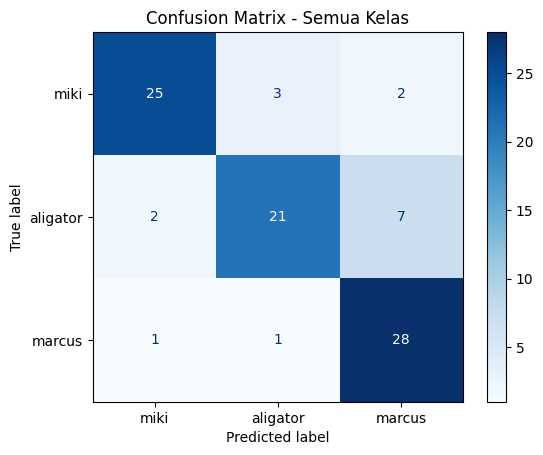

Classification Report - Semua Kelas:
              precision    recall  f1-score   support

        miki       0.89      0.83      0.86        30
    aligator       0.84      0.70      0.76        30
      marcus       0.76      0.93      0.84        30

    accuracy                           0.82        90
   macro avg       0.83      0.82      0.82        90
weighted avg       0.83      0.82      0.82        90

              precision    recall  f1-score    support
miki           0.892857  0.833333  0.862069  30.000000
aligator       0.840000  0.700000  0.763636  30.000000
marcus         0.756757  0.933333  0.835821  30.000000
accuracy       0.822222  0.822222  0.822222   0.822222
macro avg      0.829871  0.822222  0.820509  90.000000
weighted avg   0.829871  0.822222  0.820509  90.000000


In [ ]:
# Inisialisasi
y_true_all2 = []
y_pred_all2 = []

# Loop untuk mengumpulkan prediksi dan label dari seluruh test data
for image_batch, label_batch in classification_test_ds_32:
    predictions = clf_model_class2.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true_all2.extend(label_batch.numpy())
    y_pred_all2.extend(predicted_labels)

# Confusion Matrix
cm = confusion_matrix(y_true_all2, y_pred_all2)
display_labels = [label_map[i] for i in sorted(set(y_true_all2 + y_pred_all2))]  # label_map = {0: "Kelas 1", 1: "Kelas 2", 2: "Kelas 3"}
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Visualisasi
plt.figure(figsize=(8, 6))
disp2.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Semua Kelas")
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report - Semua Kelas:")
print(classification_report(y_true_all2, y_pred_all2, target_names=display_labels))

# (Opsional) Tampilkan sebagai DataFrame
report_df2 = pd.DataFrame(
    classification_report(
        y_true_all2,
        y_pred_all2,
        target_names=display_labels,
        output_dict=True
)
).transpose()
print(report_df2)

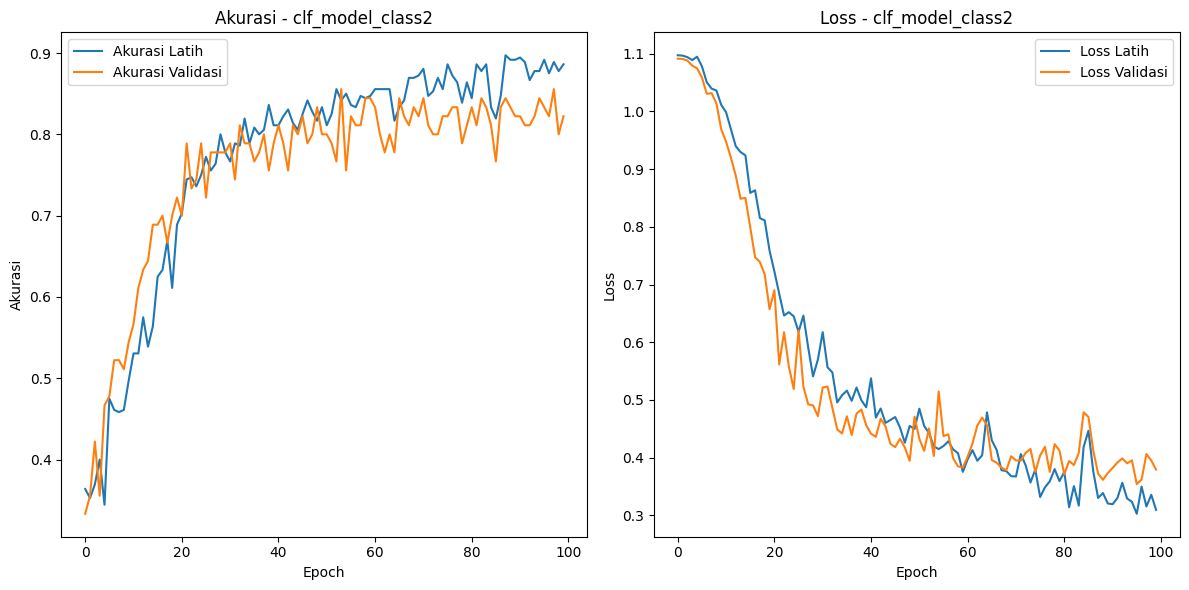

In [ ]:
# Plot History untuk clf_model_class2
plt.figure(figsize=(12, 6))

# Plot Akurasi dan Loss untuk clf_model_class2
plt.subplot(1, 2, 1)  # Subplot pertama untuk akurasi
plt.plot(history_class2.history['accuracy'], label='Akurasi Latih')
plt.plot(history_class2.history['val_accuracy'], label='Akurasi Validasi')
plt.title("Akurasi - clf_model_class2")
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='best')

plt.subplot(1, 2, 2)  # Subplot kedua untuk loss
plt.plot(history_class2.history['loss'], label='Loss Latih')
plt.plot(history_class2.history['val_loss'], label='Loss Validasi')
plt.title("Loss - clf_model_class2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


##**VISUALISASI AKHIR**##

In [ ]:
# Warna RGB untuk setiap kelas
COLOR_MAP = {
    0: [0, 255, 0],    # marcus → hijau
    1: [0, 0, 255],    # miki → biru
    2: [255, 0, 0],    # aligator → merah
}

def colorize_binary_mask(mask, label_idx):
    color = tf.constant(COLOR_MAP.get(label_idx, [255, 255, 255]), dtype=tf.uint8)
    mask = tf.cast(mask > 0.5, tf.uint8)
    mask_rgb = tf.repeat(mask, repeats=3, axis=-1) * color
    return mask_rgb

In [ ]:
def visualize_all_test_images(image_paths, mask_paths, labels, unet_model, clf_model, label_map, max_visualize=None):
    label_names = {v: k for k, v in label_map.items()}
    num_samples = len(image_paths)

    if max_visualize is not None:
        num_samples = min(num_samples, max_visualize)

    for i in range(num_samples):
        image_path = image_paths[i]
        mask_path = mask_paths[i]
        true_label_idx = labels[i]

        # Load image
        image_raw = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.image.resize(image, [128, 128])
        image = tf.cast(image, tf.float32) / 255.0

        # Load ground truth mask
        try:
            mask_raw = tf.io.read_file(mask_path)
            gt_mask = tf.image.decode_jpeg(mask_raw, channels=1)
            gt_mask = tf.image.resize(gt_mask, [128, 128])
            gt_mask = tf.cast(gt_mask, tf.float32)
        except:
            gt_mask = tf.zeros((128, 128, 1), dtype=tf.float32)

        # Predict mask with U-Net
        pred_mask = unet_model(tf.expand_dims(image, 0), training=False)
        pred_mask = tf.squeeze(pred_mask, 0)

        # Apply predicted mask for feature extraction
        masked_image = apply_unet_segmentation_to_image(image, pred_mask)

        # Predict label with classifier
        pred_probs = clf_model(tf.expand_dims(masked_image, 0), training=False)
        pred_label_idx = int(tf.argmax(pred_probs, axis=-1).numpy()[0])

        # Convert label to string
        true_label_str = label_names.get(true_label_idx, f"Unknown ({true_label_idx})")
        pred_label_str = label_names.get(pred_label_idx, f"Unknown ({pred_label_idx})")

        # Visualisasi
        fig, axes = plt.subplots(1, 5, figsize=(22, 5))
        axes[0].imshow(image.numpy())
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(colorize_binary_mask(gt_mask, true_label_idx))
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis('off')

        axes[2].imshow(tf.squeeze(pred_mask), cmap='gray')
        axes[2].set_title("Predicted Mask (U-Net)")
        axes[2].axis('off')

        axes[3].imshow(masked_image.numpy())
        axes[3].set_title("Masked Image (Fitur Ekstraksi)")
        axes[3].axis('off')

        axes[4].imshow(masked_image.numpy())
        axes[4].set_title(f"Label Asli: {true_label_str}\nPrediksi: {pred_label_str}")
        axes[4].axis('off')

        filename = image_path.split('/')[-1]
        plt.suptitle(f"Visualisasi: {filename}", fontsize=14, y=1.05)
        plt.tight_layout()
        plt.show()

In [ ]:
# Cetak warna untuk setiap jenis daun tanpa menampilkan RGB
mapping = {
    "marcus": "merah",
    "miki": "hijau",
    "aligator": "biru"
}

print("Daftar warna ground truth untuk setiap jenis daun:")
for label, warna in mapping.items():
    print(f"- {label}: {warna}")


visualize_all_test_images(
    test_image_paths,
    test_mask_paths,
    test_labels,
    unet_model,
    clf_model,
    label_map,
    max_visualize=25  # Ganti jumlah yang ingin divisualisasikan
)

Daftar warna ground truth untuk setiap jenis daun:
- marcus: merah
- miki: hijau
- aligator: biru


TypeError: visualize_all_test_images() missing 1 required positional argument: 'label_map'